In [9]:
import os
os.chdir(r'C:\Users\sokin\Documents\Zoocamp\Homework-2')
os.getcwd()

'C:\\Users\\sokin\\Documents\\Zoocamp\\Homework-2'

In [341]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, expon, probplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set_theme(style='darkgrid')
import warnings
warnings.filterwarnings("ignore")

In [93]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


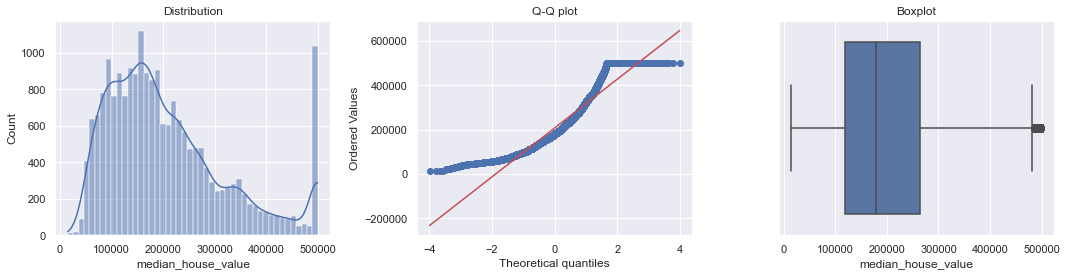

kurtosis: 0.3275001388119616 || skewness: 0.9776922140978416
the median house value has: 5.19 % outliers
the average value of the outliers is: 499267


In [97]:
plt.figure(figsize=(15, 4))

plt.subplot(131)  # 1 row, 3 columns, 1st subplot
sns.histplot(df['median_house_value'], kde=True)
plt.title("Distribution")

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
probplot(df.median_house_value, dist="norm", plot=plt)
plt.title("Q-Q plot")

plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
sns.boxplot(data=df, x='median_house_value')
plt.title("Boxplot")

plt.tight_layout()  # Ensures proper spacing
plt.show()

##########################################
Q1 = np.percentile(df.median_house_value, 25)
Q3 = np.percentile(df.median_house_value, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = np.where((df.median_house_value < lower_bound) | (df.median_house_value > upper_bound))[0]

print('kurtosis:',kurtosis(df.median_house_value), '|| skewness:',skew(df.median_house_value))
print('the median house value has:',round(100*len(outliers)/len(df),2),'% outliers')
print('the average value of the outliers is:',int(df.median_house_value[outliers].mean()))

# Question 1

In [229]:
dt = df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')][['latitude', 'longitude', 'housing_median_age', \
                    'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']]

In [230]:
dt.isna().sum()
print('feature with missing values: total_bedrooms')

feature with missing values: total_bedrooms


# Question 2

In [231]:
print('median for population:', dt.population.median())

median for population: 1195.0


# Question 3

In [232]:
dt_full_train, dt_test = train_test_split(dt, test_size=0.2, random_state=42) # full train, test
dt_train, dt_val = train_test_split(dt_full_train, test_size=0.25, random_state=42) # train, validation

Text(0.5, 1.0, 'log(1 + median house value)')

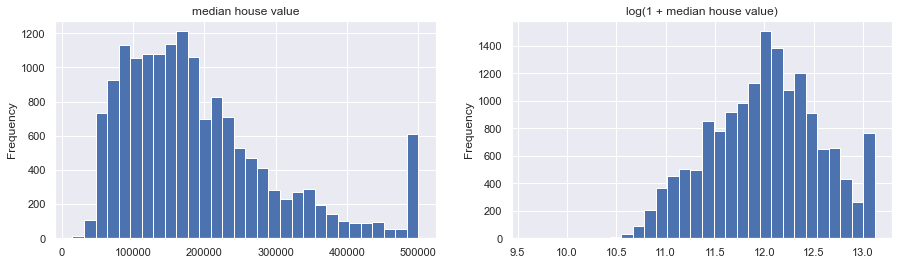

In [241]:
plt.figure(figsize=(15, 4))

plt.subplot(121)  # 1 row, 3 columns, 1st subplot
dt.median_house_value.plot(kind='hist', bins=30, )
plt.title("median house value")

plt.subplot(122)  # 1 row, 3 columns, 1st subplot
np.log1p(dt.median_house_value).plot(kind='hist', bins=30)
plt.title("log(1 + median house value)")

In [242]:
y_train_orig = dt_train.median_house_value.values
y_val_orig = dt_val.median_house_value.values
y_test_orig = dt_test.median_house_value.values

y_train = np.log1p(dt_train.median_house_value.values)
y_val = np.log1p(dt_val.median_house_value.values)
y_test = np.log1p(dt_test.median_house_value.values)

del dt_train['median_house_value']
del dt_val['median_house_value']
del dt_test['median_house_value']

## Method 1: fill with 0

In [309]:
dt_train_0 = dt_train.fillna(0)
dt_val_0 = dt_val.fillna(0)

In [316]:
model_0 = LinearRegression()
model_0.fit(dt_train_0, y_train)
y_pred_0 = model_0.predict(dt_val_0)

In [323]:
print('Mean price for log(1 + median house value) on train dataset:',np.mean(y_train),'with RMSE:', round(np.sqrt(mean_squared_error(y_val, y_pred_0)),2))

Mean price for log(1 + median house value) on train dataset: 12.013082615504933 with RMSE: 0.34


## Method 2: fill with mean

In [318]:
# null=dt_train[dt_train.total_bedrooms.isna()].index
# test.loc[null]
# test = dt_train.fillna(dt_train.total_bedrooms.mean())

In [319]:
dt_train_mean = dt_train.fillna(dt_train.total_bedrooms.mean())
dt_val_mean = dt_val.fillna(dt_train.total_bedrooms.mean())

In [320]:
model_mean = LinearRegression()
model_mean.fit(dt_train_mean, y_train)
y_pred_mean = model_0.predict(dt_val_mean)

In [322]:
print('Mean price for log(1 + median house value) on train dataset:',np.mean(y_train),'with RMSE:', round(np.sqrt(mean_squared_error(y_val, y_pred_mean)),2))

Mean price for log(1 + median house value) on train dataset: 12.013082615504933 with RMSE: 0.33


###### Both RMSEs are almost identical, however method 2 for mean imputation has better performance (0.33) 

# Question 4

In [325]:
alpha = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [342]:
dt_train_0 = dt_train.fillna(0)
dt_val_0 = dt_val.fillna(0)

alpha = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
test={}

for r in alpha:
    lasso_model = Lasso(alpha=r)
    lasso_model.fit(dt_train_0, y_train)

    # Make predictions
    y_pred = lasso_model.predict(dt_val_0)

    # Evaluate the model
    mse = mean_squared_error(y_val, y_pred)
    test[r]=np.round(np.sqrt(mse),2)
    
    print(f"For parameter r={r} ==> RMSE:{np.round(np.sqrt(mse),2)}")

For parameter r=0 ==> RMSE:0.34
For parameter r=1e-06 ==> RMSE:0.34
For parameter r=0.0001 ==> RMSE:0.34
For parameter r=0.001 ==> RMSE:0.34
For parameter r=0.01 ==> RMSE:0.34
For parameter r=0.1 ==> RMSE:0.38
For parameter r=1 ==> RMSE:0.54
For parameter r=5 ==> RMSE:0.55
For parameter r=10 ==> RMSE:0.55


###### It seems that we have multiple parameters with the same minimum RMSE, however we select the smallest r=0

# Question 5

In [344]:
seed_performance={}

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    dt_full_train, dt_test = train_test_split(dt, test_size=0.2, random_state=seed) # full train, test
    dt_train, dt_val = train_test_split(dt_full_train, test_size=0.25, random_state=seed) # train, validation

    y_train = np.log1p(dt_train.median_house_value.values)
    y_val = np.log1p(dt_val.median_house_value.values)
    y_test = np.log1p(dt_test.median_house_value.values)

    del dt_train['median_house_value']
    del dt_val['median_house_value']
    del dt_test['median_house_value']
    
    dt_train_0 = dt_train.fillna(0)
    dt_val_0 = dt_val.fillna(0)
    
    model_0 = LinearRegression()
    model_0.fit(dt_train_0, y_train)
    y_pred_0 = model_0.predict(dt_val_0)
    rmse = round(np.sqrt(mean_squared_error(y_val, y_pred_0)),2)
    
    seed_performance[seed] = rmse
    print(f'Seed {seed} with RMSE: {rmse}')

Seed 0 with RMSE: 0.33
Seed 1 with RMSE: 0.34
Seed 2 with RMSE: 0.33
Seed 3 with RMSE: 0.34
Seed 4 with RMSE: 0.33
Seed 5 with RMSE: 0.34
Seed 6 with RMSE: 0.34
Seed 7 with RMSE: 0.34
Seed 8 with RMSE: 0.34
Seed 9 with RMSE: 0.35


In [363]:
std = np.round(np.std(list(seed_performance.values())), 3)

In [364]:
print(f'standard deviation of scores:{std}')

standard deviation of scores:0.006


# Question 6

In [375]:
dt_full_train, dt_test = train_test_split(dt, test_size=0.2, random_state=9) # full train, test
dt_train, dt_val = train_test_split(dt_full_train, test_size=0.25, random_state=9) # train, validation

y_full_train = np.log1p(dt_full_train.median_house_value.values) 
y_train = np.log1p(dt_train.median_house_value.values)
y_val = np.log1p(dt_val.median_house_value.values)
y_test = np.log1p(dt_test.median_house_value.values)

del dt_full_train['median_house_value']
del dt_train['median_house_value']
del dt_val['median_house_value']
del dt_test['median_house_value']

# dt_train_0 = dt_train.fillna(0)
# dt_val_0 = dt_val.fillna(0)
dt_full_train_0 = dt_full_train.fillna(0)
dt_test_0 = dt_test.fillna(0)

model_0 = Lasso(alpha=0.001)
model_0.fit(dt_full_train_0, y_full_train)
y_pred_0 = model_0.predict(dt_test_0)

rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_0)),2)
print(f'RMSE on test dataset:{rmse}')

RMSE on test dataset:0.35
